In [ ]:
# 참고 https://stydy-sturdy.tistory.com/11

In [ ]:
import numpy as np
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pytz import timezone
import os

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
# 하이퍼 파라미터
Random_seed = 42 #아무 값이나 해도 되는 임의 값임.
Learning_rate = 0.0001 # 학습 진행률. 논문에서는 0.01
Batch_size = 64 # 이 단위로 학습한다.
N_epochs = 10 # 에폭 횟수 , 전체 데이터가 10번 학습 된다는 의미
Img_size = 224 # 224*224 RGB
N_classes = 10 # 데이터셋의 10개의 아웃풋 클래스가 있다.

In [ ]:
# 정확도 확인 코드
def get_accuracy(model, data_loader, device):
    correct_pred = 0
    n = 0
    with torch.no_grad():
        model.eval() # 배치 노말리제이션, 드랍아웃 같은 거 없이 모델이 평가모드로 전환
        for X, y_true in data_loader: # 데이터 셋에 있는 인풋
            X = X.to(device)
            y_true = y_true.to(device)
            _, y_prod = model(x) #y_prod는 후에 나올 모델에서 소프트맥스를 통과한 클래스 확률
            _, predicted_labels = torch.max(y_prod,1) # 열 중에서 가장 높은 값을 뽑아준다.

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()
        return correct_pred.float() / n # 정확히 맞춘것 / 총 갯수

In [ ]:
# loss 함수 
def plot_loss(train_loss, val_loss):
    plt.style.use('grayscale')
    train_loss = np.array(train_loss)
    val_loss = np.array(val_loss)
    fig, ax = plt.subplots(1,1,figsize = (8,4.5)
    ax.plot(train_loss, color = 'green', label = 'TraingLoss')
    ax.plot(val_loss, color = 'red', label = 'Validation Loss')
    ax.set(title='Loss OVer Epochs', xlabel = 'EPOCH', ylabel= 'Loss')
    ax.legend()
    fig.show()
    plt.style.use('default')

In [ ]:
# train 함수
def train(train_loader, moder, criterion, optimizer, device):
    model.train() # 모델을 학습모드로 설정
    running_loss= 0 # 초기값 0
    for X, y_true in train_loader :
        optimizer.zero_grad() #역전파시 효과적으로 학습되기 위해 설정. 매번 세팅 필요
        X = X.to(device)
        y_true = y_true.to(device)
        y_hat, _ = model(X)
        loss = criterion(y_hat, y_true) # Loss 구함
        running_loss += loss.item() * X.size(0) # 사이즈를 곱해서 전체적인 런닝 로스를 구함
        loss.backward() #역전파
        optimizer.step() #그레디언트 디센트
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

In [ ]:
# validate 함수
def validate(valid_loader, model, criterion, device):
    model.eval()
    running_loss = 0
    for X, y_true in valid_loader :
        X = X.to(device)
        y_true = y_true.to(device)
        
        #순전파와 손실 기록
        y_hat, _ = model(X) #소프트 맥스 당하기 전
        loss = criterion(y_hat, y_true)
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
    return model, epoch_loss

In [ ]:
# Training_loop 함수
def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_evry=1):
    # 매트릭스 저장 객체 설정
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # 모델 학습
    for epoch in range(0, epochs):
        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, device)
        train_losses.append(train_loss)
        # vaildation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every -1):
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, train_loader, device=device)

            print(datetime.now(timezone('Asia/Seoul')).time().replace(microsecond=0), '---', 
                  f'Eoch:{epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {train_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}\t')

    plot_loss(train_losses, valid_losses)
    return model, optimizer, (train_losses, valid_losses)

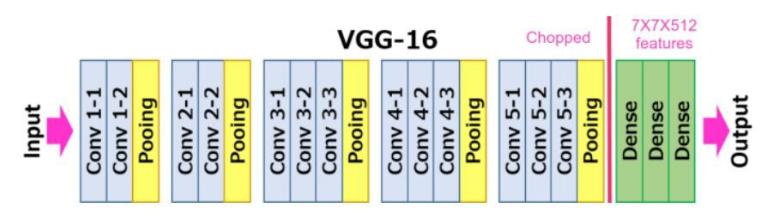

In [ ]:
# Class VGG16
# conv1

# classfier

# 맥스풀링 5번 사용해서 2**5만큼 줄어들어 7x7 되고, 마지막 채널수는 512

In [1]:
class VGG16(nn.Module):

    def __init__(self, n_classes):
        super(VGG16, self).__init__()

        self.feature_extractor = nn.Sequential(
            # 1층 in 3x224x224
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1,padding=1), #Bias default
            nn.ReLU(),
           
            # 2층 in 64x224x224
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # default stride = kernel_size
            
            # 3층 in 64x112x112
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),

            # 4층 in 64x112x112
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),            
            nn.MaxPool2d(kernel_size=2),

            # 5층 in 128x56x56
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),

            # 6층 in 256x56x56
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),   

            # 7층 in 256x56x56
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2),

            # 8층 in 256x28x28
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),   
            
            # 9층 in 512x28x28
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),

            # 10층 in 512x28x28
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2),

            # 11층 in 512x14x14
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),

            # 12층 in 512x14x14
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),

            # 13층 in 512x14x14
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1,padding=1),
            nn.ReLU(),  
            nn.MaxPool2d(kernel_size=2),                                                
        )
  
        self.classifier = nn.Sequential(
            # 14층 in 512x7x7 = 25088  플랫튼
            nn.Linear(in_features = 25088, out_features = 4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            # 15층 in 4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Dropout(0.5),

            # 16층 in 4096
            nn.Linear(in_features=4096, out_features=n_classes)
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1) # 1차원으로 쫙펴준다
        logits = self.classifier(x) # classifier에 통과시켜준다
        probs = F.softmax(logits, dim=1) # 나온 10개의 값들을 softmax로 확률 구해준다.
        return logits, probs

NameError: name 'nn' is not defined

In [ ]:
# 데이터 불러오기 + 체크
# specify a data path
path2data = '/data'

# if not exists the path, make the directory
if not os.path.exists(path2data):
    os.mkdir(path2data)

# load dataset
train_ds = datasets.STL10(path2data, split='train', download=True, transform=transforms.ToTensor())
val_ds = datasets.STL10(path2data, split='test', download=True, transform=transforms.ToTensor())

plt.imshow(train_ds.data[1].T , cmap = 'gray_r') #대충 어떤 이미지가 있나 봅시다.
print(len(train_ds)) # train data의 개수
print(len(val_ds)) # test data의 개수
train_ds[0][0].shape

# 5000개의 training 데이터와 8000개의 validation 데이터가 있음을 확인할 수 있다. 이미지의 사이즈는 96*96 이다.

In [ ]:
# 이미지 전처리
# 효과적인 학습을 위해 데이터에 torchvision.transforms.Nomalize()를 진행
# To normalize the dataset, calculate the mean and std
train_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in train_ds]
train_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in train_ds]

train_meanR = np.mean([m[0] for m in train_meanRGB])
train_meanG = np.mean([m[1] for m in train_meanRGB])
train_meanB = np.mean([m[2] for m in train_meanRGB])
train_stdR = np.mean([s[0] for s in train_stdRGB])
train_stdG = np.mean([s[1] for s in train_stdRGB])
train_stdB = np.mean([s[2] for s in train_stdRGB])


val_meanRGB = [np.mean(x.numpy(), axis=(1,2)) for x, _ in val_ds]
val_stdRGB = [np.std(x.numpy(), axis=(1,2)) for x, _ in val_ds]

val_meanR = np.mean([m[0] for m in val_meanRGB])
val_meanG = np.mean([m[1] for m in val_meanRGB])
val_meanB = np.mean([m[2] for m in val_meanRGB])

val_stdR = np.mean([s[0] for s in val_stdRGB])
val_stdG = np.mean([s[1] for s in val_stdRGB])
val_stdB = np.mean([s[2] for s in val_stdRGB])

print(train_meanR, train_meanG, train_meanB)
print(val_meanR, val_meanG, val_meanB)
#0.4467106 0.43980986 0.40664646
#0.44723064 0.4396425 0.40495726

In [ ]:
# transforms를 정의하고, 이미지를 여러장 불러와 다시 한번 확인

# transforms 정의하기
transforms_set = transforms.Compose([transforms.Resize((256,256)),transforms.RandomCrop((224,224)),transforms.ToTensor(),
                                  transforms.Normalize([train_meanR, train_meanG, train_meanB], [train_stdR, train_stdG, train_stdB])])

# 불러온 MNIS data 확인하기
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_ds.data[index].T, cmap='gray_r')
fig.suptitle('For VGG Dataset - preview');

In [ ]:
# 정의한 transforms를 train, validate 데이터셋에 적용하고, 변환된 이미지 사이즈를 확인하자.
train_ds.transform = transforms_set
val_ds.transform = transforms_set
train_ds[0][0].size()
#torch.Size([3, 224, 224])

In [ ]:
# data loader 정의하기
train_loader = DataLoader(dataset=train_ds,
                          batch_size=Batch_size,
                          shuffle=True)

valid_loader = DataLoader(dataset=val_ds,
                          batch_size=Batch_size,
                          shuffle=False)

In [ ]:
# 학습
torch.manual_seed(Random_seed)
model = VGG16(N_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001,weight_decay=0)
criterion = nn.CrossEntropyLoss()

# 논문에서 제시한 대로 parameter을 설정했더니 학습이 진행되지 않았다. 
# 그래서 learning rate과 weight decay 값을 위 코드와 같이 설정하였다. 
# 또한 optimizer로 SGD 대신 Adam을 사용하였다.

In [ ]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader,
                                    valid_loader, N_epochs, DEVICE)

# Train Accuracy는 증가하고 있지만 Valid Accuracy는 fluctuate하고 있는 상황
# 오버피팅이 일어난 것
# 15에포크 정도에서 Early stopping을 했어야 했던 것 같다. 
# Keras에서는 Early stopping을 지원한다